<a href="https://colab.research.google.com/github/komalanchalia/foodie/blob/main/assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
project_name = 'Assignment'

In [2]:
!pip install opendatasets --upgrade --quiet

2d3780c5454445794ecaa13b2ea38153

In [3]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/crawford/cat-dataset/data'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: komalanchalia
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/crawford/cat-dataset


100%|██████████| 4.04G/4.04G [03:40<00:00, 19.7MB/s]


In [4]:
import os
data_dir = './cat-dataset'
print(os.listdir(data_dir))


['CAT_04', 'cats', 'CAT_02', 'CAT_01', 'CAT_00', 'CAT_05', 'CAT_03', 'CAT_06']


In [5]:
print(os.listdir(data_dir + '/CAT_02'))
print(os.listdir(data_dir + '/CAT_01'))
print(os.listdir(data_dir + '/CAT_03'))
print(os.listdir(data_dir + '/CAT_04'))

['00000693_014.jpg.cat', '00000590_019.jpg.cat', '00000669_005.jpg', '00000509_019.jpg', '00000612_015.jpg', '00000630_023.jpg', '00000695_019.jpg.cat', '00000609_001.jpg.cat', '00000696_017.jpg', '00000561_009.jpg', '00000553_003.jpg.cat', '00000536_006.jpg.cat', '00000523_028.jpg.cat', '00000541_010.jpg.cat', '00000596_019.jpg.cat', '00000523_017.jpg', '00000612_027.jpg.cat', '00000520_012.jpg', '00000645_002.jpg', '00000547_025.jpg.cat', '00000537_012.jpg', '00000567_024.jpg.cat', '00000527_021.jpg.cat', '00000539_006.jpg', '00000694_022.jpg', '00000659_027.jpg', '00000596_010.jpg', '00000666_005.jpg', '00000650_015.jpg.cat', '00000511_024.jpg.cat', '00000654_016.jpg.cat', '00000623_023.jpg', '00000642_005.jpg.cat', '00000631_028.jpg', '00000674_019.jpg', '00000560_024.jpg', '00000517_002.jpg', '00000582_029.jpg.cat', '00000660_029.jpg', '00000522_028.jpg', '00000525_025.jpg.cat', '00000685_007.jpg', '00000541_001.jpg.cat', '00000579_020.jpg.cat', '00000594_010.jpg', '00000535_028.j

In [6]:
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [7]:
image_size = 64
batch_size = 128
stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

In [8]:
train_ds = ImageFolder(data_dir, transform=T.Compose([
    T.Resize((image_size, image_size)),
    T.RandomCrop((image_size, image_size)),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def denorm(img_tensors):
  return img_tensors * stats[1][0] + stats[0][0]

In [11]:
def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break

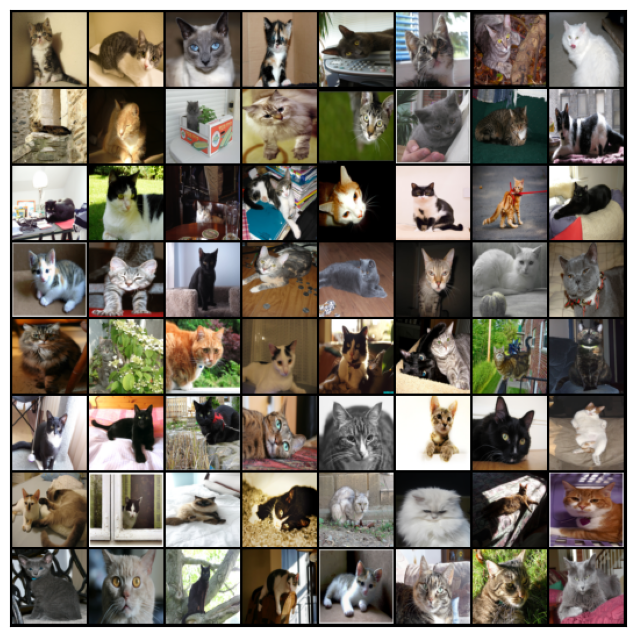

In [12]:
show_batch(train_dl )

In [13]:
!pip install jovian --upgrade --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 5.8 MB/s eta 0:00:00


In [14]:
import jovian
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


In [15]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [16]:
device = get_default_device()
device



device(type='cuda')

In [17]:
train_dl = DeviceDataLoader(train_dl, device)

In [18]:
import torch.nn as nn
import torch.nn.functional as F

In [19]:
discriminator = nn.Sequential(

       nn.Conv2d(3,64, kernel_size=4, stride=2, padding=1,bias=False),
       nn.BatchNorm2d(64),
       nn.LeakyReLU(0.2, inplace=True),

       nn.Conv2d(64,128, kernel_size=4, stride=2, padding=1,bias=False),
       nn.BatchNorm2d(128),
       nn.LeakyReLU(0.2, inplace=True),

       nn.Conv2d(128,256, kernel_size=4, stride=2, padding=1,bias=False),
       nn.BatchNorm2d(256),
       nn.LeakyReLU(0.2, inplace=True),

       nn.Conv2d(256,512, kernel_size=4, stride=2, padding=1,bias=False),
       nn.BatchNorm2d(512),
       nn.LeakyReLU(0.2, inplace=True),

       nn.Conv2d(512,1,kernel_size=4, stride=1, padding=0, bias=False),


       nn.Flatten(),
       nn.Sigmoid()
)





In [20]:
discriminator = to_device(discriminator, device)

In [21]:
latent_size = 128

In [22]:
generator = nn.Sequential(

       nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
       nn.BatchNorm2d(512),
       nn.ReLU(True),

       nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
       nn.BatchNorm2d(256),
       nn.ReLU(True),

       nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
       nn.BatchNorm2d(128),
       nn.ReLU(True),

       nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
       nn.BatchNorm2d(64),
       nn.ReLU(True),

       nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
       nn.Tanh()
)

create random tensors gaussian

torch.Size([128, 128, 1, 1])
torch.Size([128, 3, 64, 64])


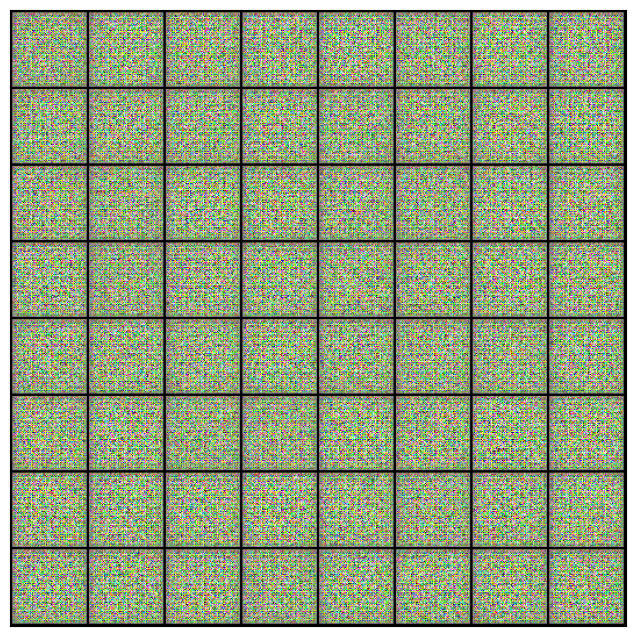

In [23]:
xb = torch.randn(batch_size, latent_size, 1, 1)
print(xb.shape)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [24]:
generator = to_device(generator, device)

discriminator training *binary classifier

In [25]:
def train_discriminator(real_images, opt_d):
  opt_d.zero_grad()

  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0), 1, device=device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score



genarator training

In [26]:
def train_generator(opt_g):
  opt_g.zero_grad()

  latent = torch.randn(batch_size, latent_size,1,1,device=device)
  fake_images = generator(latent)

  preds = discriminator(fake_images)
  targets = torch.ones(batch_size, 1, device=device)
  loss = F.binary_cross_entropy(preds, targets)

  loss.backward()
  opt_g.step() #update the weights of the generator

  return loss.item()

In [27]:
from torchvision.utils import save_image

In [28]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [29]:
def save_samples(index, latent_tensors, show=True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
  print('Saving',fake_fname)
  if show:
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [30]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


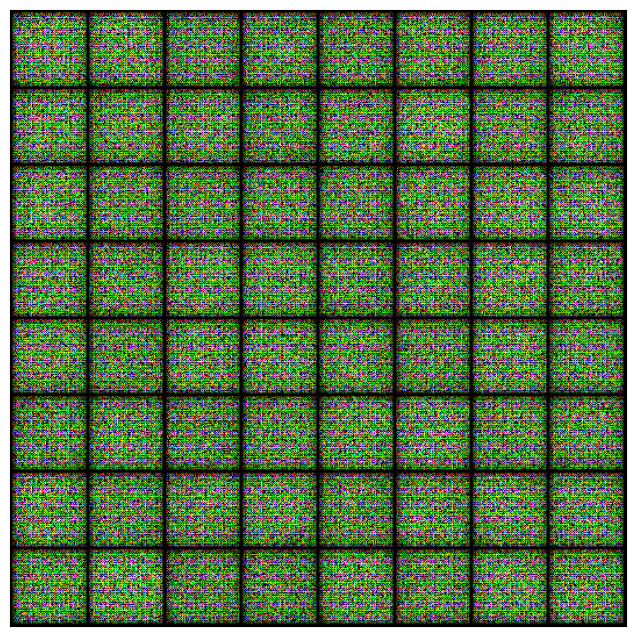

In [31]:
save_samples(0,fixed_latent)

In [32]:
jovian.commit(project=project_name,environment=None)

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


In [33]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [34]:
def fit(epochs, lr, start_idx=1):
  torch.cuda.empty_cache()

  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

  for epoch in range(epochs):
    for i, (real_images, _) in enumerate(tqdm(train_dl)): # Added enumerate to track index 'i'
      loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
      loss_g = train_generator(opt_g)

    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    print("Epoch [{}/{}], Step [{}/{}], loss_g:{:.4f}, loss_d:{:.4f}, real_score:{:.4f}, fake_score:{:.4f}"
                  .format(epoch+1, epochs,i+1, len(train_dl), loss_g, loss_d, real_score, fake_score)) # Updated len(train_loader) to len(train_dl)

    save_samples(epoch+start_idx, fixed_latent, show=False)

  return losses_g, losses_d, real_scores, fake_scores

In [37]:
lr= 0.0002
epochs = 20

In [36]:
jovian.reset()
jovian.log_hyperparams(lr=lr, epochs=epochs)

[jovian] Please enter your API key ( from https://jovian.com/ ):
API KEY: ··········
[jovian] Hyperparams logged.


In [38]:
history = fit(epochs, lr)

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [1/20], Step [157/157], loss_g:5.3908, loss_d:0.3814, real_score:0.8903, fake_score:0.2087
Saving generated-images-0001.png


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [2/20], Step [157/157], loss_g:3.4292, loss_d:0.3975, real_score:0.8673, fake_score:0.2009
Saving generated-images-0002.png


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [3/20], Step [157/157], loss_g:1.5996, loss_d:0.9881, real_score:0.4664, fake_score:0.0424
Saving generated-images-0003.png


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [4/20], Step [157/157], loss_g:1.9701, loss_d:0.7629, real_score:0.6230, fake_score:0.1549
Saving generated-images-0004.png


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [5/20], Step [157/157], loss_g:4.4449, loss_d:0.6704, real_score:0.7858, fake_score:0.3025
Saving generated-images-0005.png


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [6/20], Step [157/157], loss_g:4.0314, loss_d:0.4243, real_score:0.8796, fake_score:0.2336
Saving generated-images-0006.png


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [7/20], Step [157/157], loss_g:2.6325, loss_d:0.6168, real_score:0.7146, fake_score:0.2004
Saving generated-images-0007.png


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [8/20], Step [157/157], loss_g:4.5909, loss_d:0.4192, real_score:0.9724, fake_score:0.3008
Saving generated-images-0008.png


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [9/20], Step [157/157], loss_g:8.5465, loss_d:1.2557, real_score:0.9858, fake_score:0.6560
Saving generated-images-0009.png


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [10/20], Step [157/157], loss_g:2.7973, loss_d:0.3312, real_score:0.7843, fake_score:0.0700
Saving generated-images-0010.png


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [11/20], Step [157/157], loss_g:4.7301, loss_d:0.2402, real_score:0.8788, fake_score:0.0879
Saving generated-images-0011.png


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [12/20], Step [157/157], loss_g:2.4258, loss_d:0.4098, real_score:0.7756, fake_score:0.1070
Saving generated-images-0012.png


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [13/20], Step [157/157], loss_g:1.5047, loss_d:0.9341, real_score:0.4777, fake_score:0.0882
Saving generated-images-0013.png


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [14/20], Step [157/157], loss_g:2.7478, loss_d:0.3785, real_score:0.7734, fake_score:0.0821
Saving generated-images-0014.png


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [15/20], Step [157/157], loss_g:5.7113, loss_d:0.5384, real_score:0.9009, fake_score:0.3171
Saving generated-images-0015.png


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [16/20], Step [157/157], loss_g:3.6887, loss_d:0.2932, real_score:0.8262, fake_score:0.0791
Saving generated-images-0016.png


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [17/20], Step [157/157], loss_g:3.6492, loss_d:0.3624, real_score:0.9233, fake_score:0.2189
Saving generated-images-0017.png


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [18/20], Step [157/157], loss_g:5.3899, loss_d:0.8100, real_score:0.9497, fake_score:0.4766
Saving generated-images-0018.png


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [19/20], Step [157/157], loss_g:4.5461, loss_d:0.3821, real_score:0.9256, fake_score:0.2385
Saving generated-images-0019.png


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [20/20], Step [157/157], loss_g:4.2079, loss_d:0.6525, real_score:0.8910, fake_score:0.3658
Saving generated-images-0020.png


In [39]:
losses_g, losses_d, real_scores, fake_scores = history

In [40]:
jovian.log_metrics(generator_loss=losses_g[-1], discriminator_loss=losses_d[-1], real_score=real_scores[-1], fake_score=fake_scores[-1])

[jovian] Metrics logged.


In [41]:
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

visulaize the progress in form of video

In [42]:
import cv2
import os

vid_fname= 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out=cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release

<function VideoWriter.release>

epochs bhout low hai isliye graph does not really give good ideas

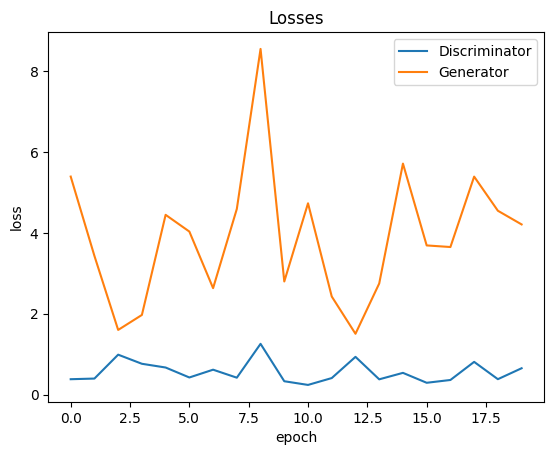

In [43]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

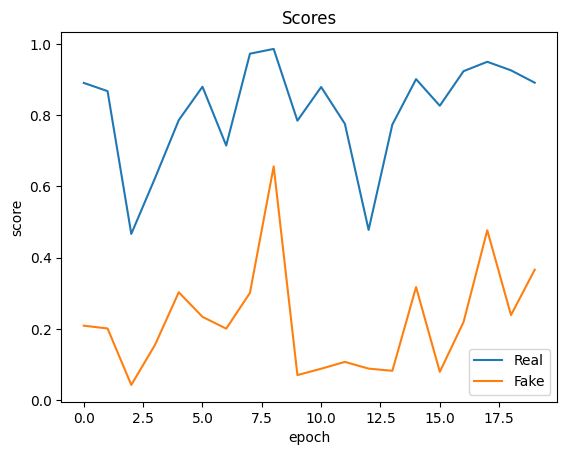

In [44]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [ ]:
import jovian

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.
